<a href="https://colab.research.google.com/github/Andreas-Horvat/sesam/blob/master/BERT_NER_comparision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <center>**Analyse der Named Entity Recognition des KI-Modells BERT in einer spezifischen Sprachdomäne**</center>
**<center> Praktische Ausarbeitung der Bachelorarbeit </center>**

Vorgehen: 
1. Fine Tuning vom BERT auf die Named Entity Recognition (NER) mit Trainingsdaten aus einer spezifischen Sprachdomäne
2. Bereitstellen des DSLIM Modell, ein bereits mit Trainingsdaten aus einer allgemeiner Sprachdomäne (CoNLL-2003) auf die NER feinabgestimmt
3. Ein qualitativer Vergleich der beiden Modelle in der NER auf Testdaten aus der spezifischen Sprachdomäne

Voraussetgesetzte Installation:
- Transformer (huggingface)
- PyTorch 

In [ ]:
!pip install transformers==3.5.1 
!pip install seqeval
!pip install -U -q PyDrive



Vorbereiten der Trainings- und Testdaten

In [ ]:
from pathlib import Path
from sklearn.model_selection import train_test_split
from transformers import Trainer, TrainingArguments, BertForTokenClassification, BertTokenizerFast
import torch
import numpy as np


# DATASET
# 1. download EWNERTC_All_Versions.zip dataset from https://data.mendeley.com/datasets/cdcztymf4k/1
# 2. unzip EWNERTC_ALL_Versions/ETWNERTC_TC_Coarse Grainied NER_DomainDependent_NoiseReduction.DUMP
# dataset format Domain\tAnnotation\tSentence e.g music\tO B-PERSON I-PERSON O\tHi Max Mustermann .


# PREPARE DATASETS
"""
Takes the record from the path variable.
Searches for all lines with the domain string paramerter, 
then shortens the resulting list of lines depending on the parameter factor.
Afterwards it splits the lines into a list of tag lists and a list of word lists.
At least it tokenized the tags and words inside the lists.
Returns:
token_docs e.g.[ ..., ['O', 'O', 'B-PERSON', 'I-PERSON', 'B-LOCALIZATION', 'O'], ...]
token_tags e.g. [..., ['Hello', 'Please', ',', 'girls', ',', "c'mon,"], ...]
"""


def read_ewnerct(file_path, domain, length):
    file_path = Path(file_path)
    file = open(file_path, 'r', encoding='utf-8')
    domain_lines = get_domain_lines(file, domain)
    file.close()
    reduced_lines = domain_lines[:length]
    tag_lists, text_lists = split_tags_texts(reduced_lines)
    return tokenize_tag_word(tag_lists, text_lists)


# get the specific domain lines of the dataset
def get_domain_lines(file, domain):
    domain_lines = []
    for line in file.readlines():
        if line.startswith(domain):
            domain_lines.append(line)
    return domain_lines


# get the tags as a list and the corresponding words as a list from a domain line
def split_tags_texts(domain_lines):
    tag_lists = []
    text_lists = []
    for list in domain_lines:
        tag_lists.append([list.split('\t')[1]])
        text_lists.append([list.split('\t')[2]])
    return tag_lists, text_lists


# separates the elements within a list of strings by whitespaces
def tokenize_tag_word(tag_lists, text_lists):
    tags_lists = []
    word_lists = []
    for tag in tag_lists:
        tags_lists.append(tag[0].split())
    for text in text_lists:
        word_lists.append(text[0].split())
    return tags_lists, word_lists


# read dataset and save in lists /lenght is amount of lines to get correct amount of the data
tags, words = read_ewnerct(
    './sample_data/music_file',
    'music', 18705)

# map the tags that differ from the CoNLL-2003 Tagset to the CoNLL Format Explanation:
# map() essentially applies a function on top of the object i being passed,
# which are the sub-lists of tags. In this case we want to apply .get(x) from the scoring dictionary on each mark (x)
# within the sub-lists (i) in tags.
# Combined with list comprehension it gives you all transformed scores as a new list of lists.
tags = [list(map(lambda x: {'B-PERSON': 'B-PER', 'I-PERSON': 'I-PER', 'B-LOCATION': 'B-LOC', 'I-LOCATION': 'I-LOC',
                            'B-ORGANZIATION': 'B-ORG', 'I-ORGANIZATION': 'I-ORG', 'B-MISC': 'B-MISC',
                            'I-MISC': 'I-MISC',
                            'O': 'O'}.get(x), i)) for i in tags]

# split dataset in a training set and a validation set
train_texts, test_texts, train_tags, test_tags = train_test_split(words, tags, test_size=.2)
print('train sentences: ' + str(len(train_tags)))
print('test sentences: ' + str(len(test_tags)))
# static id2label, label2id from dslim/bert-base-NER/config.json to quaranty
id2label = {0: "O", 1: "B-MISC", 2: "I-MISC", 3: "B-PER", 4: "I-PER", 5: "B-ORG", 6: "I-ORG", 7: "B-LOC", 8: "I-LOC"}
label2id = {"B-LOC": 7, "B-MISC": 1, "B-ORG": 5, "B-PER": 3, "I-LOC": 8, "I-MISC": 2, "I-ORG": 6, "I-PER": 4, "O": 0}
# get pre-trained tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')
# create encodings for the tokens and tags
train_encodings = tokenizer(train_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True,
                            truncation=True)

test_encodings = tokenizer(test_texts, is_split_into_words=True, return_offsets_mapping=True, padding=True,
                           truncation=True)

"""
DistilBert’s tokenizer split the word token [beatles] into the two subtokens ['beat', '##les'],
but we only have one entity tag per token => mismatch between the amounts of token and entity tags.
To solve this, we only train on the labels (number for the entity tag) 
for the first subtoken of a split token by setting the labels we want to ignore to -100. 
if the label for beatles is for e.g. 3 (indexing B-ORGANIZATION) 
=> ['beat', '##les'] to [3, -100,].
offset_mapping gives us a tuple indicating the sub-token’s start position and end position
relative to the original token it was split from.
first position != 0 => not first subtoken => set label to -100. 
second position == 0 => special token like [PAD] or [CLS] => set label to -100
"""


def encode_tags(tags, encodings):
    # get id of each tag in tags
    # tag2id e.g {'A': 0, 'B': 1, 'C': 2,'D': 3 }
    # tags e.g [['A', 'A'], ['C', 'A', 'B']]
    # labels e.g [[0, 0], [2, 0, 1]]
    labels = [[label2id[tag] for tag in doc] for doc in tags]
    encoded_labels = []
    # encodings.offset_mapping e.g [[(0,1), (0,2), (0,0) , (0,0)], [(0,2), (2,4), (0,7), (0,0)]]
    # zip(labels, encodings.offset_mapping) e.g [ ([0, 0], [(0,0), (0,0)]), ([2, 0, 1], [(0,2), (2,4), (0,7 )]) ]
    for doc_labels, doc_offset in zip(labels, encodings.offset_mapping):
        # create an empty array of -100 = length 2
        doc_enc_labels = np.ones(len(doc_offset), dtype=int) * -100
        arr_offset = np.array(doc_offset)
        # set labels whose first offset position is 0 and the second is not 0
        doc_enc_labels[(arr_offset[:, 0] == 0) & (arr_offset[:, 1] != 0)] = doc_labels
        encoded_labels.append(doc_enc_labels.tolist())

    return encoded_labels


train_labels = encode_tags(train_tags, train_encodings)
test_labels = encode_tags(test_tags, test_encodings)


class EWNERTCDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


# remove offset_mapping we don't want to pass this to the model
train_encodings.pop("offset_mapping")
test_encodings.pop("offset_mapping")
# create a dataset object
train_dataset = EWNERTCDataset(train_encodings, train_labels)
test_dataset = EWNERTCDataset(test_encodings, test_labels)
# load in a token classification model and specify the number of labels:

# Initializing a BERT bert-base-uncased style configuration
model_specific = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(label2id))
model_dslim = BertForTokenClassification.from_pretrained("dslim/bert-base-NER",
                                                         num_labels=len(label2id))

train sentences: 14964
test sentences: 3741


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Set Up Trainer

In [ ]:

from seqeval.metrics import classification_report, recall_score, f1_score, \
    precision_score, accuracy_score
import matplotlib.pyplot as plt
# Metrics
def plot_classification_report(cr, title='Evaluation der Klassifizierung', cmap=plt.cm.Blues):

    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 5)]:
        #print(line)
        t = line.split()
        # print(t)
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        print(v)
        plotMat.append(v)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['Precision', 'Recall', 'F1-Score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Entitäten')
    plt.xlabel('Metriken')
    plt.show()

# Metrics
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    # Remove ignored index (special tokens)
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    cr = classification_report(true_labels, true_predictions)
    print(cr)
    plot_classification_report(cr)
    return {
        "accuracy_score": accuracy_score(true_labels, true_predictions),
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions),
    }

# config training arguments
training_args = TrainingArguments(
    output_dir='./results',  # output directory
    num_train_epochs=3,  # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,  # batch size for evaluation
    warmup_steps=500,  # number of warmup steps for learning rate scheduler
    weight_decay=0.01,  # strength of weight decay
    logging_dir='./logs',  # directory for storing logs
    logging_steps=10,
)


trainer_dslim = Trainer(
    model=model_dslim,  # the instantiated 🤗 Transformers model to be trained
    args=training_args,  # training arguments, defined above
    compute_metrics=compute_metrics,  # metrics, defined above
    eval_dataset=test_dataset  # evaluation dataset
)
trainer_specific = Trainer(
    model=model_specific,  # the instantiated 🤗 Transformers model to be trained
    args=training_args,  # training arguments, defined above
    compute_metrics=compute_metrics,  # metrics, defined above
    train_dataset=train_dataset,
    eval_dataset=test_dataset  # evaluation dataset
)

Start Fine Tuning Training

In [ ]:
# start training
trainer_specific.train()


Step,Training Loss
10,2.221115
20,2.133023
30,1.970155
40,1.684481
50,1.275175
60,0.901670
70,0.666296
80,0.627486
90,0.540913
100,0.476251


Evaluation BERT Fine Tuned mit Spezifischen Trainingsdaten

# EVALUATION SPECIFIC MODEL


              precision    recall  f1-score   support

         LOC       0.91      0.95      0.93       258
        MISC       0.80      0.79      0.79      8722
         PER       0.68      0.69      0.68      1494

   micro avg       0.78      0.78      0.78     10474
   macro avg       0.80      0.81      0.80     10474
weighted avg       0.78      0.78      0.78     10474

[0.91, 0.95, 0.93]
[0.8, 0.79, 0.79]
[0.68, 0.69, 0.68]


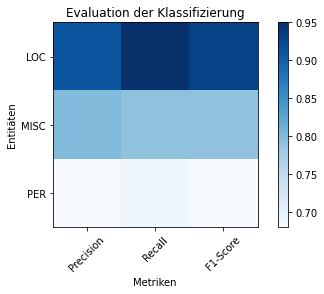

{'eval_loss': 0.19151924550533295, 'eval_accuracy_score': 0.9406772774236989, 'eval_precision': 0.7814601344860711, 'eval_recall': 0.7766851250716059, 'eval_f1': 0.7790653131583988, 'epoch': 3.0}
# EVALUATION DSLIM MODEL


/usr/local/lib/python3.6/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         LOC       0.14      0.63      0.23       258
        MISC       0.23      0.10      0.14      8722
         ORG       0.00      0.00      0.00         0
         PER       0.21      0.45      0.29      1494

   micro avg       0.17      0.16      0.16     10474
   macro avg       0.15      0.29      0.16     10474
weighted avg       0.23      0.16      0.16     10474

[0.14, 0.63, 0.23]
[0.23, 0.1, 0.14]
[0.0, 0.0, 0.0]
[0.21, 0.45, 0.29]


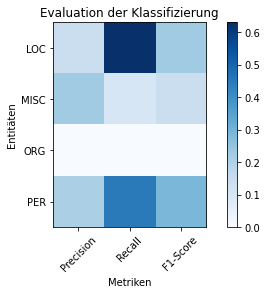

{'eval_loss': 1.8514556884765625, 'eval_accuracy_score': 0.764067379468069, 'eval_precision': 0.1662329863891113, 'eval_recall': 0.15858315829673478, 'eval_f1': 0.16231799081403303}


In [ ]:



# EVALUATION
print('# EVALUATION SPECIFIC MODEL')
print(trainer_specific.evaluate())
print('# EVALUATION DSLIM MODEL')
print(trainer_dslim.evaluate())